# Mall customer Segmentation clustering project

The data used for this project was the Mall Customer Segmentation Dataset which contains data of a hypothetical mall which wants to understand their customer base better. The purpose of this project in particular is to take the data and look for ways to cluster two segments of data together so that it can be used to help the supermarket for future strategies.

The notebook is split into 6 sections:
1. EDA (which includes feature engineering)
2. Dealing with outliers
3. Clustering Algorithms
4. PCA
5. Clustering algorithms after PCA
6. Conclusion and Future work


source(https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

## 1. Exploratory data analysis and Data visualisation (with Feature Engineering)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statistics import mean, stdev

# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [2]:
df = pd.read_csv('Mall_Customers.csv')
pd.options.display.float_format = "{:,.2f}".format
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.00,100.50,57.88,1.00,50.75,100.50,150.25,200.00
Age,200.00,38.85,13.97,18.00,28.75,36.00,49.00,70.00
Annual Income (k$),200.00,60.56,26.26,15.00,41.50,61.50,78.00,137.00
Spending Score (1-100),200.00,50.20,25.82,1.00,34.75,50.00,73.00,99.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

The "CustomerID" column is dropped as it holds little to no relevancy for this analysis as each value is unique and should have no relation to the other variables as it simply allows individual customers to be identified

In [7]:
df.drop('CustomerID', axis=1, inplace=True)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


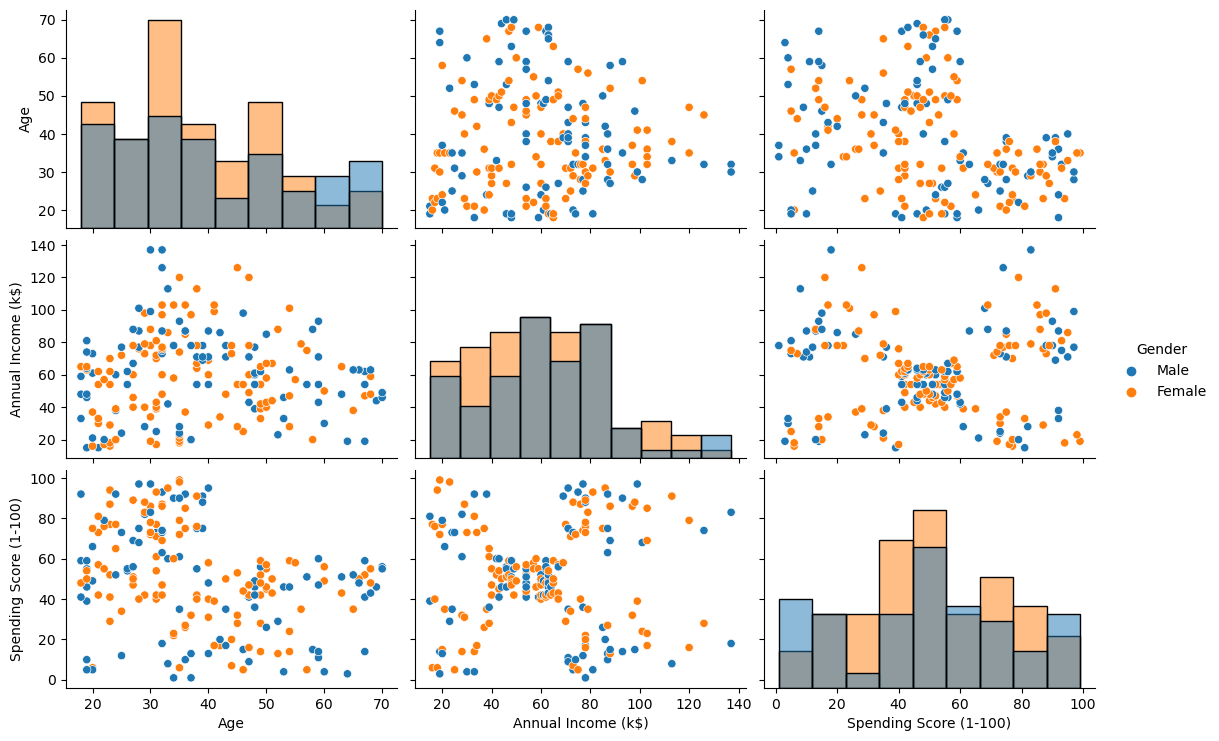

In [8]:
sns.pairplot(df, hue='Gender', diag_kind = "hist", aspect=1.5)
plt.show()

(Figure 1: Pairplot graphically showing relationship between gender and spending score, age and annnual income variables as histogram and scatterplot)

The scatter plots in figure 1 visually indicate that there is no relation between Gender and the other variables whilst the histograms indicate that the data has a fair amount of normality indicated by the rough bell shape they have. Since the Gender is not suitable for clustering based on the visual data, it will be dropped

Furthermore, The age graphs indicate weak clustering in the age scatter graphs thus this variable will be dropped for this project

In [9]:
df.drop(['Gender', 'Age'], axis=1, inplace=True)

## 2. Dealing with outliers

Box plots were made to visually check for outliers

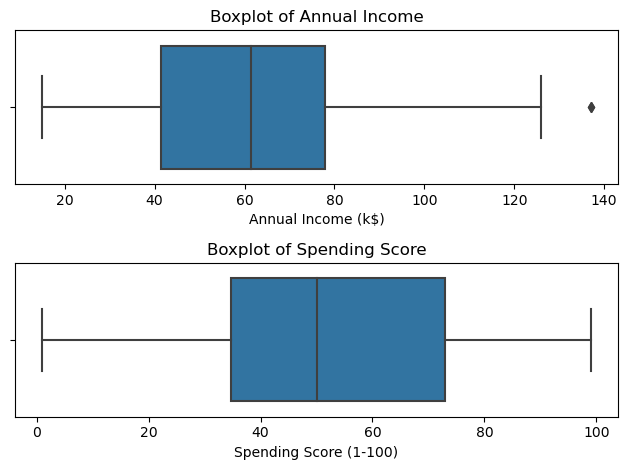

In [10]:
plt.subplot(2,1,1)
plt.title("Boxplot of Annual Income")
sns.boxplot(x = df['Annual Income (k$)'])

plt.subplot(2,1,2)
plt.title("Boxplot of Spending Score")
sns.boxplot(x= df['Spending Score (1-100)'])



plt.tight_layout()

plt.show()

The figure above shows that there is an outlier for the annual income which needs to be addressed before the machine learning models can be initalized as the clustering models used in this project are affected by outliers.

Two methods were used to remove outliers in the column of othe Pandas DataFrame:

The first was to check for datapints that are more than three standard deviations from the mean which didn't find the outlier.

The second method removed the outliers in the column of the Pandas DataFrame using the upper and lower boundary technique.


In [11]:
absolute_correlation_matrix = abs(df.corr())
print(absolute_correlation_matrix)

                        Annual Income (k$)  Spending Score (1-100)
Annual Income (k$)                    1.00                    0.01
Spending Score (1-100)                0.01                    1.00


In [12]:
# Method 1
col_mean = df["Annual Income (k$)"].mean()
col_stdev = df["Annual Income (k$)"].std()

mask = df["Annual Income (k$)"].apply(lambda x: abs(x - col_mean) > 3 * col_stdev)

outliers = df[mask]
outliers



,Annual Income (k$),Spending Score (1-100)


In [13]:
# Method 2
q1 = df["Annual Income (k$)"].quantile(0.25)
q3 = df["Annual Income (k$)"].quantile(0.75)
iqr = q3 - q1
upper_boundary = q3 + 1.5 * iqr
lower_boundary = q1 - 1.5 * iqr

mask = df["Annual Income (k$)"].between(lower_boundary, upper_boundary, inclusive=True)
filtered_df = df[mask]
filtered_df

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
193,113,91
194,120,16
195,120,79
196,126,28


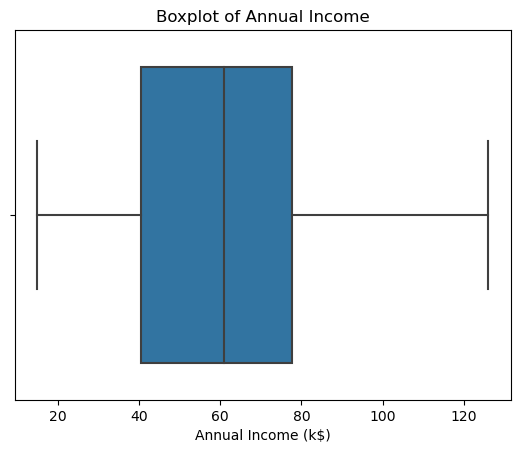

In [14]:
plt.title("Boxplot of Annual Income")
sns.boxplot(x = filtered_df['Annual Income (k$)'])
plt.show()

From the Boxplot above, it is evident that the outlier was able to be removed

## 3. Clustering Algorithms

The clustering algorithms used were the K means, Meanshift and DBScan algorithms which were then evaluated both graphically and with a silhouette score which calculates the goodness of a clustering technique between -1 and 1, with the higher score showing a better algorithm, from the scatter plot below of the two variables being focused on, it is evident that 5 clusters are expected.


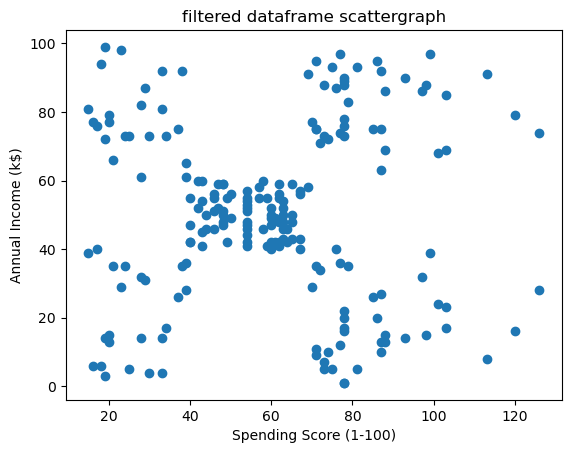

In [15]:

plt.scatter(filtered_df['Annual Income (k$)'], filtered_df['Spending Score (1-100)'])
plt.ylabel('Annual Income (k$)')
plt.xlabel('Spending Score (1-100)')
plt.title('filtered dataframe scattergraph')
plt.show()

### K means

In [16]:
from sklearn.cluster import KMeans

kmeans_filtered_df = filtered_df
filtered_df.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [17]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(kmeans_filtered_df)
kmeans_filtered_df

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
193,113,91
194,120,16
195,120,79
196,126,28


In [18]:
print(f"{km.labels_} original label")
print(f"{np.unique(km.labels_)} unique label")

[3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 1 4 0 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 0 4 1 4 1 4
 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1
 4 1 4 1 4 1 4 1 4 1 4 1 4] original label
[0 1 2 3 4] unique label


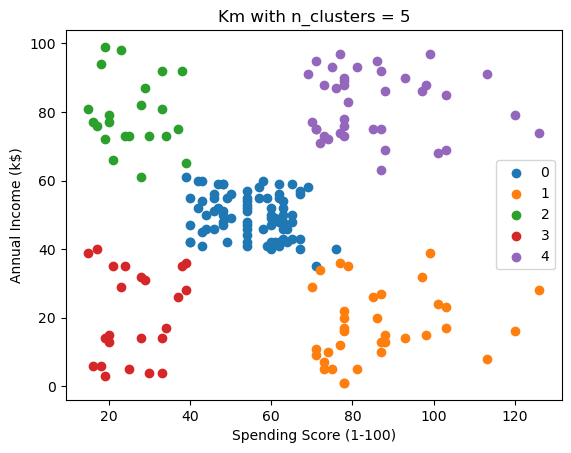

In [19]:
for label in np.unique(km.labels_):
    kmeans_filtered_df_ = kmeans_filtered_df[label == km.labels_]
    plt.scatter(kmeans_filtered_df_['Annual Income (k$)'], kmeans_filtered_df_['Spending Score (1-100)'], label=label)
plt.legend()
plt.title('Km with n_clusters = 5')
plt.ylabel('Annual Income (k$)')
plt.xlabel('Spending Score (1-100)')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score

silhouette_score_of_kmeans = silhouette_score(kmeans_filtered_df, km.labels_)

silhouette_score_dict = {}
silhouette_score_dict.update({'silhouette_score_of_kmeans':silhouette_score_of_kmeans})
print(f'Silhouette score: {silhouette_score_of_kmeans}')

Silhouette score: 0.5606825090788626


In [21]:
filtered_df.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


### Meanshift

In [22]:
from sklearn.cluster import MeanShift, estimate_bandwidth

ms_df = filtered_df
ms_df = ms_df.apply(lambda x: (x-x.mean())/(x.std()+0.0000001), axis=0)
print(filtered_df.head())
bandwidth = estimate_bandwidth(ms_df, quantile = 0.1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(ms_df)
ms_df['cluster']=ms.labels_

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


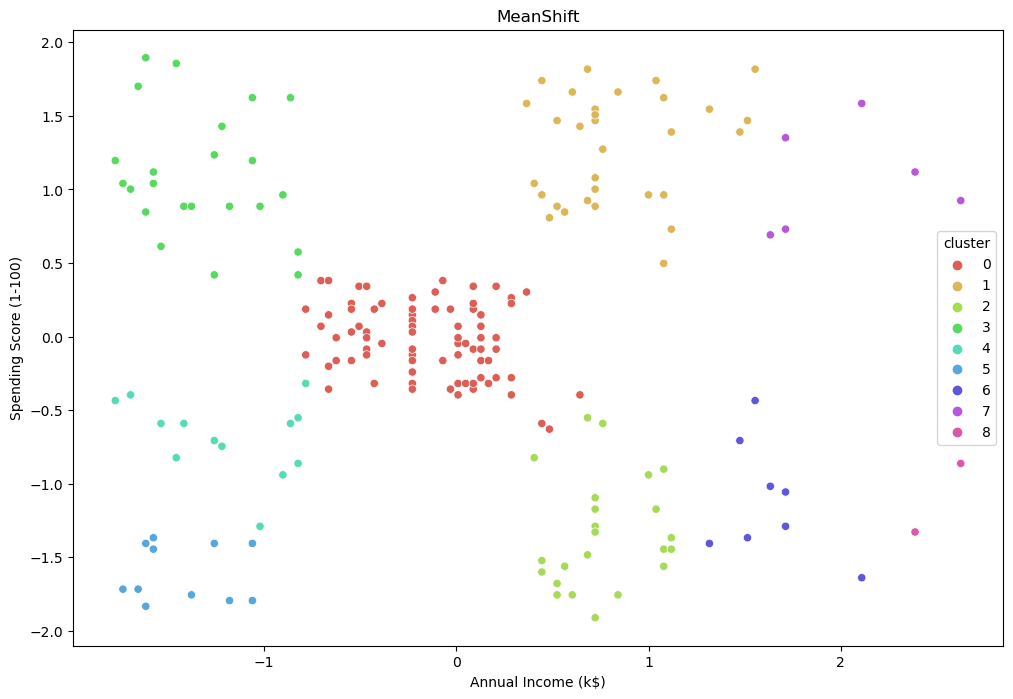

In [23]:

plt.figure(figsize=(12, 8))
sns.scatterplot(ms_df['Annual Income (k$)'], ms_df['Spending Score (1-100)'], hue=ms_df['cluster'], 
                palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
plt.plot()
plt.title('MeanShift')
plt.show()

In [24]:
silhouette_score_of_ms = silhouette_score(ms_df, ms.labels_)

silhouette_score_dict.update({'silhouette_score_of_ms':silhouette_score_of_ms})
print(f'Silhouette score: {silhouette_score_of_ms}')


Silhouette score: 0.7107516431611873


#### DBSCAN

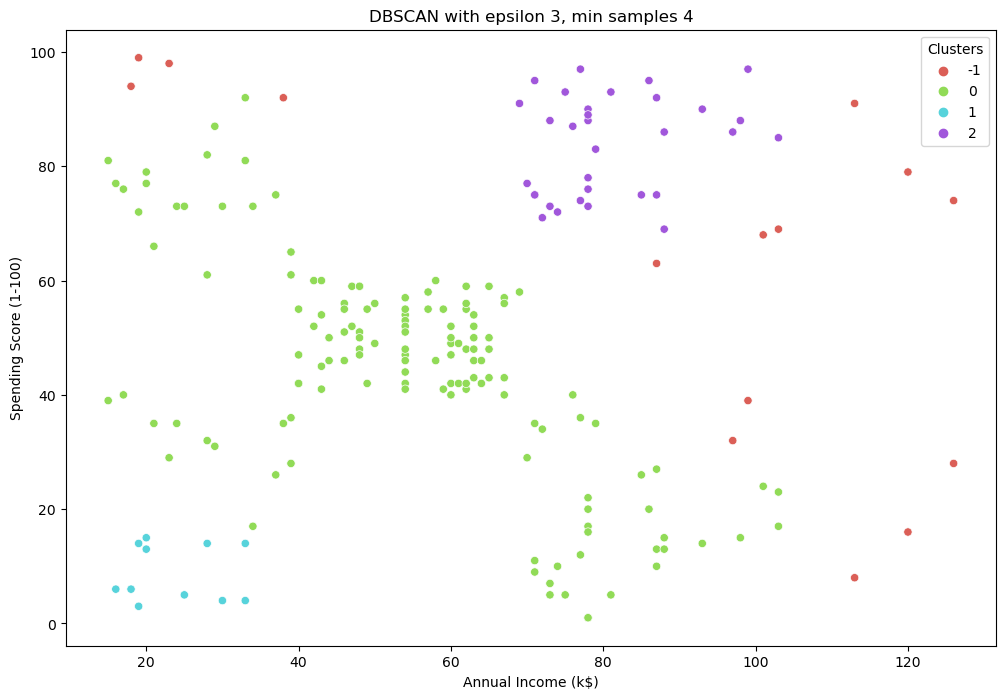

In [25]:
from sklearn.cluster import DBSCAN 
DBSCAN_df = filtered_df
# eps and min_samples was adjusted for the best plot
db = DBSCAN(eps=11, min_samples=6).fit(DBSCAN_df)
DBSCAN_df['Clusters'] = db.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(DBSCAN_df['Annual Income (k$)'], DBSCAN_df['Spending Score (1-100)'], hue=DBSCAN_df['Clusters'], 
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
plt.title('DBSCAN with epsilon 3, min samples 4')
plt.show()


In [26]:
silhouette_score_of_DBSCAN = silhouette_score(DBSCAN_df, ms.labels_)
silhouette_score_dict.update({'silhouette_score_of_DBSCAN':silhouette_score_of_DBSCAN})
print(f'Silhouette score: {silhouette_score_of_DBSCAN}')

Silhouette score: 0.4849918113809252


In [27]:
silhouette_score_dict

{'silhouette_score_of_kmeans': 0.5606825090788626,
 'silhouette_score_of_ms': 0.7107516431611873,
 'silhouette_score_of_DBSCAN': 0.4849918113809252}

## 4. PCA
Principal component analysis (PCA) was used to see if the performance of the algorithms can be improved. PCA uses linear dimensionality reduction to improve the performance of algorithms at a low cost.

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
filtered_df.drop('Clusters', axis=1, inplace=True)
X = filtered_df
scaler = StandardScaler()
X[:] = scaler.fit_transform(X)

In [30]:
pca = PCA()
pca.fit(X)
y = np.argwhere(pca.explained_variance_ratio_.cumsum() >= 0.95)[0][0] + 1
pca = PCA(n_components=y)
reduced_data = pca.fit(X).transform(X)
pca_df = pd.DataFrame(reduced_data, columns = ['Annual Income (k$)','Spending Score (1-100)',])


## 5. Clustering algorithms after PCA

#### Km with PCA

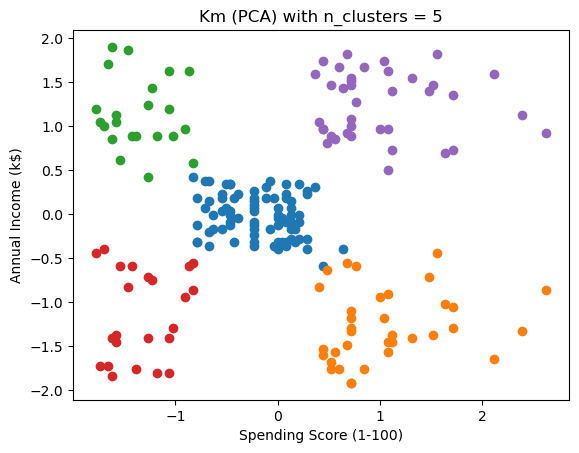

Silhouette score: 0.5162646778386364


In [31]:
km_pca = pca_df
km = KMeans(n_clusters=5, random_state=42)
km.fit(pca_df)
km_pca['Clusters']=ms.labels_


for label in np.unique(km.labels_):
    kmeans_filtered_df_ = kmeans_filtered_df[label == km.labels_]
    plt.scatter(kmeans_filtered_df_['Annual Income (k$)'], kmeans_filtered_df_['Spending Score (1-100)'], label=label)
plt.title('Km (PCA) with n_clusters = 5')
plt.ylabel('Annual Income (k$)')
plt.xlabel('Spending Score (1-100)')
plt.show()

silhouette_score_of_kmeans_with_pca = silhouette_score(km_pca, km.labels_)
silhouette_score_dict.update({'silhouette_score_of_kmeans_with_pca':silhouette_score_of_kmeans_with_pca})
print(f'Silhouette score: {silhouette_score_of_kmeans_with_pca}')

#### Mean shift with PCA

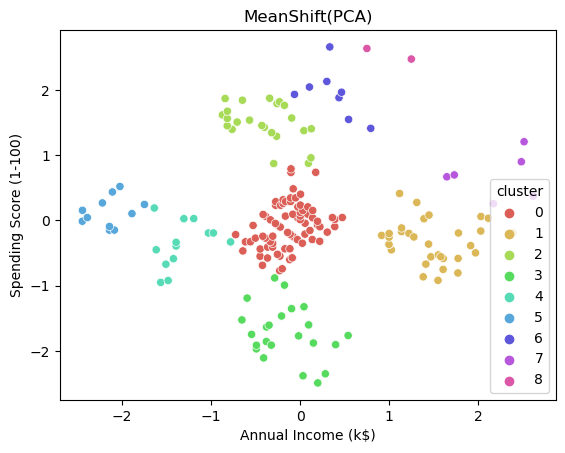

Silhouette score: 0.7471554347909701


In [32]:
ms_pca_df = pca_df
# Apply Mean Shift clustering on the transformed data
ms = MeanShift(bandwidth=1.0)
ms.fit(ms_pca_df)

# Get the cluster labels
ms_pca_df['cluster']=ms.labels_
# Plot the resulting clusters
sns.scatterplot(ms_pca_df['Annual Income (k$)'], ms_pca_df['Spending Score (1-100)'], hue=ms_pca_df['cluster'], 
                palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
plt.plot()
plt.title('MeanShift(PCA)')
plt.show()
silhouette_score_of_ms_pca = silhouette_score(ms_pca_df, ms.labels_)

silhouette_score_dict.update({'silhouette_score_of_ms_pca':silhouette_score_of_ms_pca})
print(f'Silhouette score: {silhouette_score_of_ms_pca}')

#### DBSCAN with PCA

4


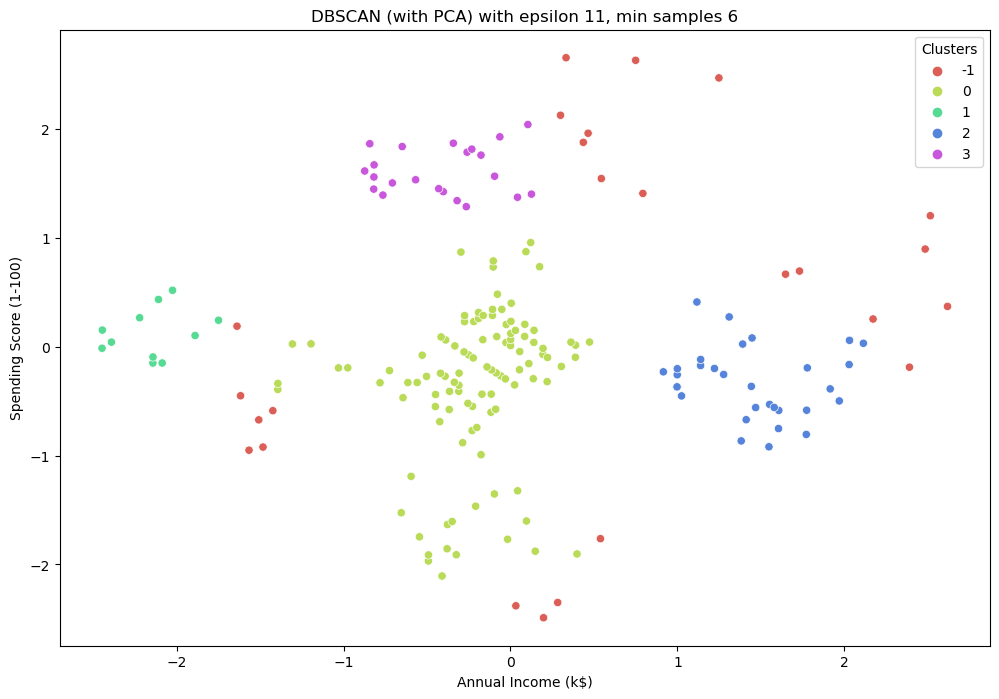

In [33]:
pca_df.drop(['Clusters', 'cluster'], axis=1, inplace=True)
DBSCAN_pca_df = pca_df

db = DBSCAN(eps=0.5, min_samples=11)
db.fit(DBSCAN_pca_df)
print(len(set(db.labels_) - {1}))
DBSCAN_pca_df['Clusters'] = db.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(DBSCAN_pca_df['Annual Income (k$)'], DBSCAN_pca_df['Spending Score (1-100)'], hue=DBSCAN_pca_df['Clusters'], 
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
plt.title('DBSCAN (with PCA) with epsilon 11, min samples 6')
plt.show()

pca_df.drop(['Clusters'], axis=1, inplace=True)


In [34]:
silhouette_score_of_DBSCAN_pca = silhouette_score(DBSCAN_pca_df, ms.labels_)
silhouette_score_dict.update({'silhouette_score_of_DBSCAN_pca':silhouette_score_of_DBSCAN_pca})
print(f'Silhouette score: {silhouette_score_of_DBSCAN}')

Silhouette score: 0.4849918113809252


In [35]:
silhouette_score_dict = dict(sorted(silhouette_score_dict.items(), key=lambda item: item[1], reverse=True))
silhouette_score_dict

{'silhouette_score_of_ms_pca': 0.7471554347909701,
 'silhouette_score_of_ms': 0.7107516431611873,
 'silhouette_score_of_kmeans': 0.5606825090788626,
 'silhouette_score_of_kmeans_with_pca': 0.5162646778386364,
 'silhouette_score_of_DBSCAN': 0.4849918113809252,
 'silhouette_score_of_DBSCAN_pca': 0.4848629974341672}

## 6. Conclusion and Future work

Using the silhouette score, the Mean shift algorithm with PCA performed the best although it produced more clusters than was expected for both PCA and non-PCA values. The K means algorithm saw a lower silhouette score after using PCA but this was negligible and graphically clustered the values the best. The DBSCAN had the lowest performance and saw a reduction in performance through the use of PCA by approx. 7.92%, although graphically it did perform better than the mean shift algorithm

As a result of the models produced, if this project were to continue, other clustering algorithms should be tested so that a high silhouette score may be found such as Agglomerative Hierarchical Clustering which groups objects in clusters based on their similarity. Furthermore, more testing can be done to fine-tune values and get the best conditions for each model through methods such as elbow plots and basic trial and error. One other possible future pathway includes utilising Kernal PCA (KPCA) which uses Non-linear dimensionality reduction